In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
from PIL import Image

In [2]:
path = "/kaggle/input/plant-pathology-2020-fgvc7/"
img_path = path + 'images/'

In [3]:
#Loading the dataset
train_df = pd.read_csv(path + 'train.csv')
test_df = pd.read_csv(path + 'test.csv')
sample = pd.read_csv(path + 'sample_submission.csv')

In [4]:
#Image File Name
train_df['img_path'] = train_df['image_id'] + '.jpg'
test_df['img_path'] = test_df['image_id'] + '.jpg'
test_df.head()

,image_id,img_path
0,Test_0,Test_0.jpg
1,Test_1,Test_1.jpg
2,Test_2,Test_2.jpg
3,Test_3,Test_3.jpg
4,Test_4,Test_4.jpg


In [5]:
#Unpivot the labels
train_label = train_df.melt(id_vars=['image_id', 'img_path'])

#Filtering the data
train_label = train_label[train_label['value'] == 1]

#Extracting image ID
train_label['id'] = [int(i[1]) for i in train_label['image_id'].str.split('_')]

#Reset the index
train_label = train_label.sort_values('id').reset_index()

#Adding label to the datasets
train_df['label'] = train_label['variable']

#Reformat the dataset
train_df = train_df[train_df.columns[[0, 5, 1, 2, 3, 4, 6]]]
print(train_label.shape)
train_df.head()

(1821, 6)


,image_id,img_path,healthy,multiple_diseases,rust,scab,label
0,Train_0,Train_0.jpg,0,0,0,1,scab
1,Train_1,Train_1.jpg,0,1,0,0,multiple_diseases
2,Train_2,Train_2.jpg,1,0,0,0,healthy
3,Train_3,Train_3.jpg,0,0,1,0,rust
4,Train_4,Train_4.jpg,1,0,0,0,healthy


In [6]:
#Encoding the labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
label_encoded = le.fit_transform(train_df['label'])
train_df['label_encoded'] = label_encoded
label_names = le.classes_
print(label_names)

['healthy' 'multiple_diseases' 'rust' 'scab']


In [7]:
train_df.head()

,image_id,img_path,healthy,multiple_diseases,rust,scab,label,label_encoded
0,Train_0,Train_0.jpg,0,0,0,1,scab,3
1,Train_1,Train_1.jpg,0,1,0,0,multiple_diseases,1
2,Train_2,Train_2.jpg,1,0,0,0,healthy,0
3,Train_3,Train_3.jpg,0,0,1,0,rust,2
4,Train_4,Train_4.jpg,1,0,0,0,healthy,0


In [8]:
#Building the Container object for images + labels

class PathologyPlantsDataset(Dataset):
    def __init__(self, data_frame, root_dir, dataset,transform = None):
        self.data_frame = data_frame
        self.root_dir = root_dir
        self.transform = transform
        self.dataset = dataset
    
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, idx):
        
        if self.dataset == "train":
            img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 1])
            img = Image.open(img_name)
            train_transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10)
            ])
            trans_img = train_transform(img)
            label = self.data_frame.iloc[idx, -1]
            if self.transform:
                image = self.transform(trans_img)

            return (image, label)
        elif self.dataset == "test":
            img_name = self.data_frame.iloc[idx, -1]
            img_path = os.path.join(self.root_dir, img_name)
            img = Image.open(img_path)
            if self.transform:
                image = self.transform(img)

            return (image, img_name)

In [9]:
#Defining the transforms to preprocess the images themselves
img_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [10]:
#Initiating the object
pathology_train = PathologyPlantsDataset(data_frame=train_df, root_dir=img_path, dataset = "train", transform=img_transform)
pathology_test = PathologyPlantsDataset(data_frame=test_df, root_dir=img_path, dataset = "test", transform=img_transform)

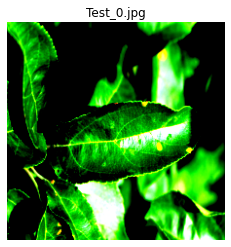

In [11]:
#Visualizing the image
import matplotlib.pyplot as plt

temp_img, temp_lab = pathology_test[0]
plt.imshow(temp_img.numpy().transpose((1, 2, 0)))
plt.title(temp_lab)
plt.axis('off')
plt.show()

In [12]:
train_loader  = DataLoader(dataset=pathology_train, batch_size=10, shuffle=True)
test_loader  = DataLoader(dataset=pathology_test, batch_size=10, shuffle=False)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
device

device(type='cuda')

In [15]:
model = torchvision.models.AlexNet()

In [16]:
model.classifier.append(nn.Linear(in_features = 1000,out_features = 500))
model.classifier.append(nn.Linear(in_features = 500,out_features = 4))

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
  (7): Linear(in_features=1000, out_features=500, bias=True)
  (8): Linear(in_features=500, out_features=4, bias=True)
)

In [17]:
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [18]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.005)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500, 1000, 1500], gamma = 0.1)

In [19]:
num_ep = 30
n_steps = len(train_loader)
for ep in range(num_ep):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        #Forward Pass
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)

        #Backward Pass
        loss.backward()
        optimizer.step()
    
    print(f'Epoch: [{ep + 1} / {num_ep}], Loss: {loss.item():.4f}')

Epoch: [1 / 30], Loss: 1.3481
Epoch: [2 / 30], Loss: 1.1887
Epoch: [3 / 30], Loss: 1.2175
Epoch: [4 / 30], Loss: 1.3204
Epoch: [5 / 30], Loss: 1.0737
Epoch: [6 / 30], Loss: 1.1534
Epoch: [7 / 30], Loss: 1.1495
Epoch: [8 / 30], Loss: 1.0742
Epoch: [9 / 30], Loss: 1.1464
Epoch: [10 / 30], Loss: 1.2841
Epoch: [11 / 30], Loss: 1.1403
Epoch: [12 / 30], Loss: 1.2158
Epoch: [13 / 30], Loss: 1.1476
Epoch: [14 / 30], Loss: 1.0714
Epoch: [15 / 30], Loss: 1.1938
Epoch: [16 / 30], Loss: 1.1699
Epoch: [17 / 30], Loss: 1.1044
Epoch: [18 / 30], Loss: 1.0975
Epoch: [19 / 30], Loss: 1.2122
Epoch: [20 / 30], Loss: 1.1067
Epoch: [21 / 30], Loss: 0.8266
Epoch: [22 / 30], Loss: 1.0132
Epoch: [23 / 30], Loss: 0.9956
Epoch: [24 / 30], Loss: 0.9511
Epoch: [25 / 30], Loss: 2.7892
Epoch: [26 / 30], Loss: 1.0701
Epoch: [27 / 30], Loss: 0.7421
Epoch: [28 / 30], Loss: 0.7925
Epoch: [29 / 30], Loss: 1.3416
Epoch: [30 / 30], Loss: 0.9878


In [20]:
import csv
batch_size = 10
with torch.no_grad():
    fields = ["image_id", "healthy", "multiple_disease", "rust", "scab"]
    filename = "submission.csv"
    filepath = os.path.join("/kaggle/working/", filename)
    batch_data = []
    m = nn.Softmax(dim = 1)
    for img, name in test_loader:
        img = img.to(device)
        output = model(img)
        pred = m(output).cpu().detach().tolist()
        for i,j in zip(pred, name):
            data = [j[:-4]]
            print(data)
            data.extend(i)
            batch_data.append(data)
            
    with open(filepath, 'w') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(fields)
        csvwriter.writerows(batch_data)
    

['Test_0']
['Test_1']
['Test_2']
['Test_3']
['Test_4']
['Test_5']
['Test_6']
['Test_7']
['Test_8']
['Test_9']
['Test_10']
['Test_11']
['Test_12']
['Test_13']
['Test_14']
['Test_15']
['Test_16']
['Test_17']
['Test_18']
['Test_19']
['Test_20']
['Test_21']
['Test_22']
['Test_23']
['Test_24']
['Test_25']
['Test_26']
['Test_27']
['Test_28']
['Test_29']
['Test_30']
['Test_31']
['Test_32']
['Test_33']
['Test_34']
['Test_35']
['Test_36']
['Test_37']
['Test_38']
['Test_39']
['Test_40']
['Test_41']
['Test_42']
['Test_43']
['Test_44']
['Test_45']
['Test_46']
['Test_47']
['Test_48']
['Test_49']
['Test_50']
['Test_51']
['Test_52']
['Test_53']
['Test_54']
['Test_55']
['Test_56']
['Test_57']
['Test_58']
['Test_59']
['Test_60']
['Test_61']
['Test_62']
['Test_63']
['Test_64']
['Test_65']
['Test_66']
['Test_67']
['Test_68']
['Test_69']
['Test_70']
['Test_71']
['Test_72']
['Test_73']
['Test_74']
['Test_75']
['Test_76']
['Test_77']
['Test_78']
['Test_79']
['Test_80']
['Test_81']
['Test_82']
['Test_83']
['